Revenue Growth vs Data Traffic Growth Monetisation,“heavy data usage, low spend” which is exactly our target group of business interest problem

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [9]:
df = pd.read_csv("Sample_dataset.csv")  # adjust filename
print(df.shape)
print(df.head())

(70, 12)
  SubscriberID SubscriptionStartDate  PlanType Region    DeviceType  \
0         S001             3/15/2022  Postpaid  Urban    Smartphone   
1         S002             8/10/2021   Prepaid  Urban    Smartphone   
2         S003             12/1/2020  Postpaid  Rural  FeaturePhone   
3         S004            11/20/2022   Prepaid  Urban    Smartphone   
4         S005              5/5/2021  Postpaid  Rural    Smartphone   

   MonthlyDataGB  MonthlyVoiceMins  MonthlySpendRs  DataGB_Last3Mo_Avg  \
0           42.5               320             550                40.2   
1           12.3                90             180                11.5   
2            4.7                60             140                 5.0   
3           55.0               400             700                50.1   
4           33.8               250             450                30.5   

   SpendRs_Last3Mo_Avg  DataGB_SpendRs_Ratio  IsUnderMonetisedFlag  
0                  540                0.0789      

In [10]:
features_num = [
    "MonthlyDataGB",
    "MonthlyVoiceMins",
    "MonthlySpendRs",
    "DataGB_Last3Mo_Avg",
    "SpendRs_Last3Mo_Avg",
    "DataGB_SpendRs_Ratio"
]
features_cat = [
    "PlanType",
    "Region",
    "DeviceType"
]

In [11]:
df_clean = df[features_num + features_cat].dropna().copy()
print("Cleaned dataset shape:", df_clean.shape)

Cleaned dataset shape: (70, 9)


In [13]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

num_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])
cat_transformer = Pipeline(steps=[
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(transformers=[
    ("num", num_transformer, features_num),
    ("cat", cat_transformer, features_cat)
])

X = preprocessor.fit_transform(df_clean)

In [14]:
best_k = None
best_score = -1
for k in range(2, 11):               # try k = 2 to 10
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X)
    score = silhouette_score(X, labels)
    print(f"k = {k}, silhouette score = {score:.4f}")
    if score > best_score:
        best_score = score
        best_k = k

print("\nBest k by silhouette score:", best_k)

k = 2, silhouette score = 0.5195
k = 3, silhouette score = 0.5317
k = 4, silhouette score = 0.5423
k = 5, silhouette score = 0.5747
k = 6, silhouette score = 0.5642
k = 7, silhouette score = 0.5494
k = 8, silhouette score = 0.5379
k = 9, silhouette score = 0.5651
k = 10, silhouette score = 0.5447

Best k by silhouette score: 5


In [15]:
k_final = 5
kmeans = KMeans(n_clusters=k_final, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X)

In [16]:
df_clean["cluster"] = cluster_labels

In [17]:
for c in range(k_final):
    sub = df_clean[df_clean["cluster"] == c]
    print(f"\nCluster {c} — count = {len(sub)}")
    print("Avg MonthlyDataGB:", sub["MonthlyDataGB"].mean())
    print("Avg MonthlySpendRs:", sub["MonthlySpendRs"].mean())
    print("Avg DataGB_SpendRs_Ratio:", sub["DataGB_SpendRs_Ratio"].mean())


Cluster 0 — count = 21
Avg MonthlyDataGB: 25.214285714285715
Avg MonthlySpendRs: 319.5238095238095
Avg DataGB_SpendRs_Ratio: 0.07892380952380952

Cluster 1 — count = 17
Avg MonthlyDataGB: 52.27058823529411
Avg MonthlySpendRs: 681.1764705882352
Avg DataGB_SpendRs_Ratio: 0.07677647058823531

Cluster 2 — count = 14
Avg MonthlyDataGB: 6.228571428571428
Avg MonthlySpendRs: 159.64285714285714
Avg DataGB_SpendRs_Ratio: 0.03875714285714286

Cluster 3 — count = 8
Avg MonthlyDataGB: 34.6125
Avg MonthlySpendRs: 467.5
Avg DataGB_SpendRs_Ratio: 0.07415

Cluster 4 — count = 10
Avg MonthlyDataGB: 15.060000000000002
Avg MonthlySpendRs: 231.5
Avg DataGB_SpendRs_Ratio: 0.06494


Cluster 1: heavy data usage 52 GB, high spend ₹681, and a ratio of 0.0768 GB/Rs. This suggests high-usage and reasonably high spend — likely “well-monetised” heavy users.

Cluster 0: moderate usage 25 GB but relatively low spend ₹319 compared to usage. Ratio ~0.0789 — slightly higher than cluster 1’s ratio. This suggests a possible “under-monetised” group: they use significant data but pay less per GB.

Cluster 3: usage ~34.6 GB, spend ~₹467.5, ratio ~0.0742 — somewhat in between. Probably “medium usage / medium spend”.

Cluster 4: usage ~15 GB, spend ~₹231.5, ratio ~0.0649 — lower usage and moderate spend; ratio lower than cluster 0, so more efficient monetisation per GB.

Cluster 2: very low usage 6.2 GB, low spend ₹159.6, ratio ~0.0388 — these are light users; likely low usage & low spend; monetisation per GB is low.

In [30]:
print(df_clean['MonthlyDataGB'].dtype, df_clean['MonthlyDataGB'].isna().sum())
print(df_clean['MonthlySpendRs'].dtype, df_clean['MonthlySpendRs'].isna().sum())

float64 0
int64 0


In [36]:
print(df_clean[['cluster','MonthlyDataGB','MonthlySpendRs']].value_counts().head(10))
print(df_clean['cluster'].unique())

cluster  MonthlyDataGB  MonthlySpendRs
0        18.7           275               1
         19.3           275               1
         19.6           280               1
         20.0           290               1
         21.4           300               1
         22.1           300               1
         22.9           300               1
         23.7           310               1
         24.2           320               1
         24.8           300               1
Name: count, dtype: int64
[1 4 2 3 0]


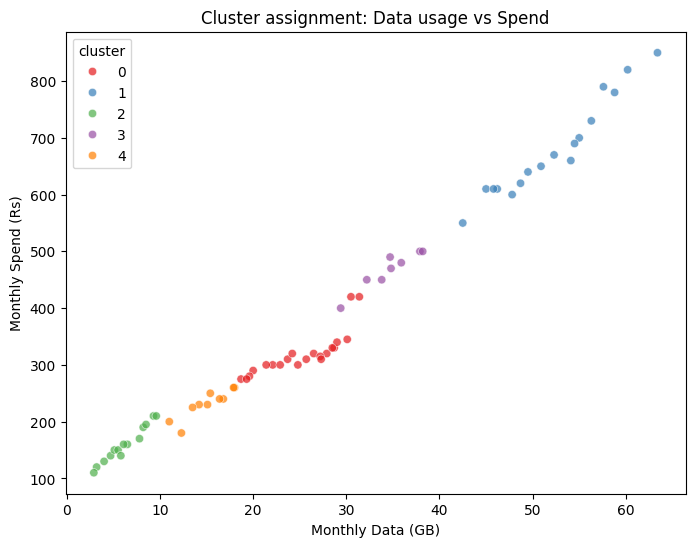

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
ax = sns.scatterplot(
   data = df_clean,
   x = "MonthlyDataGB",
   y = "MonthlySpendRs",
   hue = "cluster",
   palette = "Set1",
   alpha = 0.7
)
ax.set_title("Cluster assignment: Data usage vs Spend")
ax.set_xlabel("Monthly Data (GB)")
ax.set_ylabel("Monthly Spend (Rs)")
plt.show()

In [40]:
import pandas as pd


cluster_counts = df_full['cluster'].value_counts().sort_index()
print("Subscriber counts per cluster:")
print(cluster_counts)


device_mix = pd.crosstab(df_full['cluster'], df_full['DeviceType'], normalize='index') * 100
print("\nDevice type mix (%) by cluster:")
print(device_mix.round(2))


region_mix = pd.crosstab(df_full['cluster'], df_full['Region'], normalize='index') * 100
print("\nRegion mix (%) by cluster:")
print(region_mix.round(2))


plan_mix = pd.crosstab(df_full['cluster'], df_full['PlanType'], normalize='index') * 100
print("\nPlan type mix (%) by cluster:")
print(plan_mix.round(2))



summary = metrics.copy()
summary['Count'] = cluster_counts
summary = summary[['Count', 'MonthlyDataGB', 'MonthlySpendRs', 'DataGB_SpendRs_Ratio']]
print("\nCluster summary table:")
print(summary.round(2))


Subscriber counts per cluster:
cluster
0.0    21
1.0    17
2.0    14
3.0     8
4.0    10
Name: count, dtype: int64

Device type mix (%) by cluster:
DeviceType  FeaturePhone  Smartphone
cluster                             
0.0                  0.0       100.0
1.0                  0.0       100.0
2.0                100.0         0.0
3.0                  0.0       100.0
4.0                  0.0       100.0

Region mix (%) by cluster:
Region    Rural   Urban
cluster                
0.0        0.00  100.00
1.0        0.00  100.00
2.0       35.71   64.29
3.0      100.00    0.00
4.0       90.00   10.00

Plan type mix (%) by cluster:
PlanType  Postpaid  Prepaid
cluster                    
0.0           0.00   100.00
1.0          94.12     5.88
2.0          57.14    42.86
3.0          87.50    12.50
4.0           0.00   100.00

Cluster summary table:
         Count  MonthlyDataGB  MonthlySpendRs  DataGB_SpendRs_Ratio
cluster                                                            
0.0       

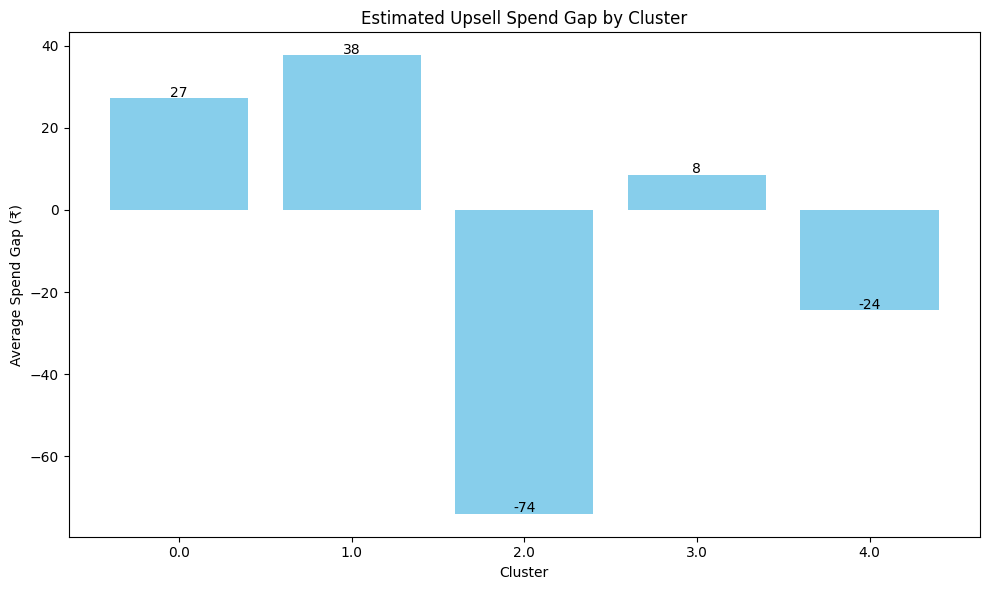

In [39]:
import matplotlib.pyplot as plt
clusters = upsell_potential.index.astype(str)
gaps = upsell_potential['spend_gap'].values

plt.figure(figsize=(10,6))
plt.bar(clusters, gaps, color='skyblue')
plt.title("Estimated Upsell Spend Gap by Cluster")
plt.xlabel("Cluster")
plt.ylabel("Average Spend Gap (₹)")
plt.xticks(rotation=0)
for i, v in enumerate(gaps):
    plt.text(i, v + (max(gaps)*0.01), f"{v:.0f}", ha='center')
plt.tight_layout()
plt.show()


In [35]:
import pandas as pd

MonthlyDataGB      = float(input("Enter MonthlyDataGB (GB): "))
MonthlyVoiceMins   = float(input("Enter MonthlyVoiceMins: "))
MonthlySpendRs     = float(input("Enter MonthlySpendRs (Rs): "))
DataGB_Last3Mo_Avg  = float(input("Enter DataGB_Last3Mo_Avg (GB): "))
SpendRs_Last3Mo_Avg = float(input("Enter SpendRs_Last3Mo_Avg (Rs): "))

PlanType   = input("Enter PlanType (e.g., Prepaid or Postpaid): ")
Region     = input("Enter Region (e.g., Urban or Rural): ")
DeviceType = input("Enter DeviceType (e.g., Smartphone or FeaturePhone): ")


if MonthlySpendRs != 0:
    DataGB_SpendRs_Ratio = MonthlyDataGB / MonthlySpendRs
else:
    DataGB_SpendRs_Ratio = 0

new_user = pd.DataFrame([{
    "MonthlyDataGB":       MonthlyDataGB,
    "MonthlyVoiceMins":    MonthlyVoiceMins,
    "MonthlySpendRs":      MonthlySpendRs,
    "DataGB_Last3Mo_Avg":  DataGB_Last3Mo_Avg,
    "SpendRs_Last3Mo_Avg": SpendRs_Last3Mo_Avg,
    "DataGB_SpendRs_Ratio": DataGB_SpendRs_Ratio,
    "PlanType":            PlanType,
    "Region":              Region,
    "DeviceType":          DeviceType
}])

print("Computed DataGB_SpendRs_Ratio:", DataGB_SpendRs_Ratio)


X_new = preprocessor.transform(new_user)
cluster_label = kmeans.predict(X_new)[0]

print(f"Assigned Cluster: {cluster_label}")

cluster_summary = upsell_potential.loc[cluster_label]
print(f"\nCluster {cluster_label} Profile:")
print(cluster_summary.round(2))


Enter MonthlyDataGB (GB): 54
Enter MonthlyVoiceMins: 66
Enter MonthlySpendRs (Rs): 88
Enter DataGB_Last3Mo_Avg (GB): 89
Enter SpendRs_Last3Mo_Avg (Rs): 548
Enter PlanType (e.g., Prepaid or Postpaid): Prepaid
Enter Region (e.g., Urban or Rural): Urban
Enter DeviceType (e.g., Smartphone or FeaturePhone): Smartphone
Computed DataGB_SpendRs_Ratio: 0.6136363636363636
Assigned Cluster: 0

Cluster 0 Profile:
MonthlyDataGB      25.21
MonthlySpendRs    319.52
spend_gap          27.22
count              21.00
Name: 0.0, dtype: float64
